South King County Opportunity Youth
===================

#### Backround
The Seattle Regional Partnership(SRP) would like an update on the estimated number of OY in South King County. However, that estimation comes from a report that is over three years old. The task was to update the SRP on the current status of OY in South King County using updated data from https://data.census.gov/.

This project offers an updated estimate of the number of Opportunity Youth in South King County using the 2017 5-year American Community Survey. 


<h1>Importing Libraries and Database </h1>

In [170]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data import data_collection
import matplotlib.image as mpimg
%matplotlib inline

In [57]:
DBNAME = "opportunity_youth"

In [58]:
conn = psycopg2.connect(dbname=DBNAME)

### Query

We pull the data for the PUMAs (separate regions studied, defined by population and the edges of census tracts) that we are interested in.  We need employment information, education information, and ages.  We pull the data for everyone, not just opportunity youth so we can compare their prevalence to total population.

##### Choice of Regions

We chose the following regions to look at because they closely mirrored the school districts studied in the 2016 road map report. <br/>

1.Federal Way, Des moines Cities & Vashon island,<br/>
2. Kent City,<br/>
3. Burien, SeaTac, Tukwita Cities,<br/>
4. Auburn City & Lakeland,<br/>
5. South East Seattle,<br/>
6. Maple Valley, Covingtion and Enumclaw Cities,<br/>
7. Renton City, Fairwood, Bryn Mawr and Skyway<br/>


##### Sample Weights

Finally, we pull the sample weights, since only a fraction of the population was polled for this dataset.

In [59]:
query = """
SELECT esr, schl education_attained, sch enrollment_status, agep age, pwgtp sample_weight
FROM pums_2017
where puma between '11610' and '11615'
or puma = '11604'
"""
df = pd.read_sql(query, conn)

#### Data Cleaning

##### Employment

For our employment data we want as complete a dataset as possible, so set missing values in esr to '3' with the assumption that missing values represent non-employed samples.

We made this choice for 2 reasons:

1. We assume folks are more likely to report that they are employed than if they are not.
2. We want to avoid under-countring our opportunity youths.

In [60]:
df['employed'] = 1
df.loc[(df.esr == '3') | (df.esr == '6'),'employed'] = 0
df.esr.fillna('3', inplace = True)
df.drop(columns = ['esr'], inplace = True)

In [61]:
df.to_csv('full_database.csv', index = False)

<h1>Estimating Population of Opportunity Youth</h1>
We created another data frame to calculate the OY by region using the same rational from above, but including the regions. 

In [65]:
ty_df = pd.read_csv('../exploratory/tables/ty_df.csv')
oy_df = pd.read_csv('../exploratory/tables/oy_df.csv')

In [128]:
#a list of the estimated population by each region and the total population for all 7 regions
population = oy_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
estimated_population = sum(population)

#a list of the youth by each region and the total youth population for all 7 regions
ty_population = ty_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
ty_estimated_population = sum(ty_population)

print(f'The total population of OY in South King County is: {estimated_population}')

The total population of OY in South King County is: 11530.0


The population of Opporuntity youth is lower than the 2016 Road maps report suggesting the regions chosen were not the same.

<h1>Setting up data for graphing</h1>


The Names of the pumas were hardcoded into the dictionary using the information from [here](https://usa.ipums.org/). Latitude, longitude were also hardcoded into the dictionary because these values will not change and were going to be used for mapping purposes. 

In [129]:
# dictionary of Puma number, and then sorting it by the OY population of each puma
# Used to organize the names of the puma which wasnt included in the dataframe
import operator
region_dic = {'11612': [population[11612],'Federal Way,Des moines Cities & Vashon island', 47.3223, -122.3126, 110, ty_population[11612]],
 '11613': [population[11613],'Kent City',47.3809, -122.2348, 34.43, ty_population[11613]],
 '11611': [population[11611],'Burien, SeaTac, Tukwita Cities',47.4668, -122.3405, 31, ty_population[11611]],
 '11614': [population[11614],'Auburn City & Lakeland', 47.3073, -122.2285, 35, ty_population[11614]],
 '11604': [population[11604],'South East Seattle', 47.5923, -122.3022, 30.5, ty_population[11604]],
 '11615': [population[11615],'Maple Valley, Covingtion and Enumclaw Cities', 47.3903, -122.0454, 18, ty_population[11615]],
 '11610': [population[11610],'Renton City, Fairwood, Bryn Mawr and Skyway', 47.4797, -122.2079, 31, ty_population[11610]]}

sort_region_dic = dict(sorted(region_dic.items(), key=operator.itemgetter(1), reverse = True))

<h1>Plotting Information</h1>
Created a bar graph comparing the Estimated Population per region
and a map showing these results

No handles with labels found to put in legend.


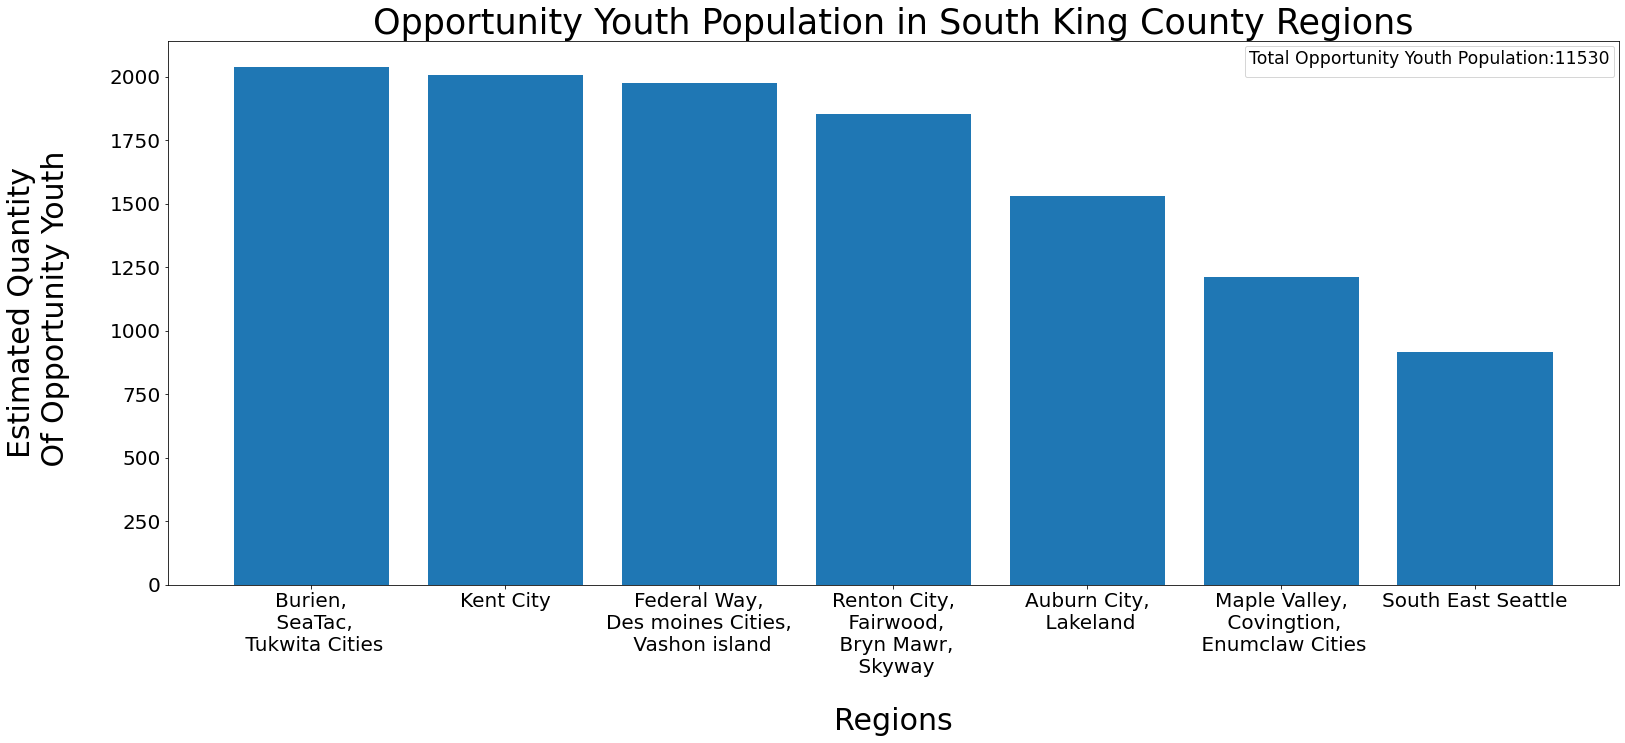

In [130]:
city_list = [item[1] for item in sort_region_dic.values()]  # created a list of the cities based on the region_dic 
estimated_population_region = [item[0] for item in sort_region_dic.values()] # created a listed of the estimated population per region
# adjusted city list so the string is on muliple lines in the graph
city_list_adj = [sub.replace(',',',\n').replace(' &',',\n').replace(' and',',\n') for sub in city_list]

#Printing a Bar graph of the population estimate per each puma(region)
figure, ax = plt.subplots(1, 1, figsize = (26,10));

x = city_list_adj;
y = estimated_population_region;
ax.bar(x, y);


ax.set_ylabel('Estimated Quantity\n Of Opportunity Youth', fontsize = 30, rotation = 90, labelpad = 40);
ax.set_xlabel('Regions', fontsize = 30, labelpad = 30);
ax.set_title('Opportunity Youth Population in South King County Regions', fontsize = 35);
ax.set_xticklabels(city_list_adj, wrap = True);
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(title =f'Total Opportunity Youth Population:{int(estimated_population)}' , title_fontsize= 'xx-large', fancybox=True);             

#### The results
It can be shown that the population of opporuntity youth is not evenly distributed throughout the South King county Regions. Regions South of Seattle appear to have a higher count opportunity youth. South east seattle and Maple Valey area have a relativley low population. 

<h1>Further look into the results</h1>
We used Folium and to give a visualization comparing population density of OY in each region. 

In [136]:
#imported the following libraries to graph a map.
import folium
import pandas as pd
import branca as cm
from folium.plugins import FloatImage

In [160]:
name = [i[1] for i in region_dic.values()]
population_values = [i[0] for i in region_dic.values()]
ty_population = [i[5] for i in region_dic.values()]
lat = [i[2] for i in region_dic.values()]
lon = [i[3] for i in region_dic.values()]

m = folium.Map(location=[47.45,-122.3321], zoom_start=11)

#loop through each lat,long and population. 
#
for i in range(0,len(region_dic.values())):
   folium.CircleMarker(
      location=[lat[i], lon[i]],
      popup= name[i] + ', \n OY Population %:' + str((population_values[i]/ty_population[i])*100),
      radius= 500 *(population_values[i]/ty_population[i]),
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)

#creates a legend in the upper left portion. 
colormap = cm.colormap.LinearColormap(colors=['blue','blue','blue','blue','blue'], index=[0,10,20,30,40],vmin=0,vmax=40);
colormap.caption = '% Of Opportunity Youth per Total Youth';
colormap.add_to(m);
m

### Interpretation of the results
The map above shows that the 

## Tables comparing 2016 data to 2017 data

In [161]:
opportunity_youth = pd.read_csv('../exploratory/tables/opportunity_youth.csv')
total_population = pd.read_csv('../exploratory/tables/total_population.csv')

In [162]:
opportunity_youth

,Unnamed: 0,16-18,%16-18,19-21,%19-21,22-24,%22-24,Totals,%Total
0,Opportunity Youth,1941.0,100.00,4361.0,100.00,5228.0,100.00,11530.0,100.00
1,No diploma,986.0,50.80,1180.0,27.06,1429.0,27.33,3595.0,31.18
2,HS diploma or GED,812.0,41.83,2448.0,56.13,2171.0,41.53,5431.0,47.10
3,"Some College, no degree",143.0,7.37,601.0,13.78,1098.0,21.00,1842.0,15.98
4,Degree (Associate or higher),0.0,0.00,132.0,3.03,530.0,10.14,662.0,5.74


In [163]:
total_population

,Unnamed: 0,16-18,%16-18,19-21,%19-21,22-24,%22-24,Totals,%Total
0,Total Population,33791.0,100.00,29915.0,100.00,36277.0,100.00,99983.0,100.00
1,Opportunity Youth,1941.0,5.74,4361.0,14.58,5228.0,14.41,11530.0,11.53
2,Working Without Diploma,449.0,1.33,1539.0,5.14,1737.0,4.79,3725.0,3.73
3,Not an Opportunity Youth,31850.0,94.26,25554.0,85.42,31049.0,85.59,88453.0,88.47


## Graphs comparing 2016 data to 2017 data

### Total Opportunity Youth, 2016 v. 2017 Chart

![Total Youth](Figures/OY_total_2016_2017.png)

### Opportunity Youth: No Diploma, 2016 v. 2017 Chart

![Total Youth](Figures/OY_ndiploma_20162017.png)

### Opportunity Youth: High School Diploma or GED Equivalent, 2016 v. 2017 Chart

![Total Youth](Figures/OY_HSGED_20162017.png)

### Opportunity Youth: Some College but No Degree, 2016 v. 2017 Chart

![OY College](Figures/OY_COllege_ndegree_20162017.png)

### Opportunity Youth: Degree(Associates or higher), 2016 v. 2017 Chart

![OY College](Figures/OY_degree_20162017.png)

### Graph Education Attainment for Opportunity Youth, 2016, v. 2017

![Total Youth](Figures/OY_ed_trend_20162017.png)

### 2016 v 2017 Education Trend

As can be seen in this graph, the education attainment trend between the 2016 and 2017 Opportunity Youth(OY) is similar.

We see that there is a higher percentage of OY that have high school diplomas or GED's compared to those without a diploma. It is not surprising that the latter is lower given that there are 16 to 18 year olds included in this sample, and many high school diplomas are not received before the age of 17 or 18.

From high school diploma/GED attainment, we see a continuing downward trend all the way through higher education degrees. There is a significant dip in the percentage of OY that attended some college but did not receive a degree. This tells us that a large percentage of OY do not go on with further education. 

The decline in percentage continues with OY who receive an Associates degree or higher. The low percentage of overall OY with a degree is expected due to the sharp dip in those who even begin a post-secondary education. A question that remains is regarding the declining percentage of OY who began college but did not finish to those who have a degree--what are the reasons that OY are not finishing post-secondary education once they have begun?

Given that these education attainment trends are similar between the 2016 and 2017 OY, we can conclude that there has not been a significant change in addressing the issues faced by OY to achieve an increase in educational attainment. There appears to be an especially significant barrier to continue education after receiving a high school diploma.  